In [1]:
# import functions
import idaes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom
# import HFC_IL mixture properties
from HFC32_emimTf2N_PR import configuration

# Create flash model

In [2]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

2021-03-16 14:01:33 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
The initial DOF is 7


In [3]:
# Read data
data = pd.read_csv('R32_emimTf2N.csv')
data_283= data[0:7]
data_298 = data[7:15]
data_323 = data[15:23]
data_348 = data[23:31]
print(len(data_298))
# print(data_298)

8


## code for diff kappas

In [ ]:
# initialize arrays for x and P

def calc_outlet_xP(data,k21,k12):
    R32_x = np.zeros((len(data)))
    P = np.zeros((len(data)))
    
    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

    for i in range(len(data)):
        m.fs.liq = data["x_emimTf2N"].iloc[i]
        m.fs.F101.inlet.flow_mol.fix(1) 
        m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.properties.PR_kappa['emimTf2N', 'R32'].fix(k21) # (-0.20093)
        m.fs.properties.PR_kappa['R32', 'emimTf2N'].fix(k12) # (-0.05619)

#         DOF_final = degrees_of_freedom(m)
#         print("The final DOF is {0}".format(DOF_final))

        # solver
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        solver = SolverFactory('ipopt')
        solver.options = {'tol': 1e-6}
        status = solver.solve(m, tee = False)
    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
        else:
            print('Infeasible.')
    return(R32_x,P)

In [ ]:
kappa21= np.array([-0.200,-0.30,-0.40,-0.5])
kappa12= np.array([-0.056,-0.066,-0.076,-0.086])

# plot function to see if it works - works when i store value, plot, store value 2, plot 2 etc
def plot_sens_analysis(data,kappa21,kappa12):
    
    for i in range(len(kappa21)):
        for j in range(len(kappa12)):
            x1,P1 = calc_outlet_xP(data, kappa21[i],kappa12[j])
            
            
    x1,P1= calc_outlet_xP(data, kappa21[0],kappa12[0])
    plt.plot(x1,P1,"b+-",label="K21=-0.2, K12=-0.056")
    x2,P2= calc_outlet_xP(data,kappa21[0],kappa12[1])
    plt.plot(x2,P2,"g+",label="K21=-0.2, K12=-0.066")
    x3,P3= calc_outlet_xP(data,kappa21[0],kappa12[2])
    plt.plot(x3,P3,"m+",label="K21=-0.2, K12=-0.076")
    x4,P4= calc_outlet_xP(data,kappa21[0],kappa12[3])
    plt.plot(x4,P4,"c+",label="K21=-0.2, K12=-0.086")
    x5,P5= calc_outlet_xP(data,kappa21[1],kappa12[0])
    plt.plot(x5,P5,"b*",label="K21=-0.3, K12=-0.056")
    x6,P6= calc_outlet_xP(data,kappa21[1],kappa12[1])
    plt.plot(x6,P6,"g*",label="K21=-0.3, K12=-0.066")
    x7,P7= calc_outlet_xP(data,kappa21[1],kappa12[2])
    plt.plot(x7,P7,"m*",label="K21=-0.3, K12=-0.076")
    x8,P8= calc_outlet_xP(data,kappa21[1],kappa12[3])
    plt.plot(x8,P8,"c*",label="K21=-0.3, K12=-0.086")
    x9,P9= calc_outlet_xP(data,kappa21[2],kappa12[0])
    plt.plot(x9,P9,"b^",label="K21=-0.4, K12=-0.056")
    x10,P10= calc_outlet_xP(data,kappa21[2],kappa12[1])
    plt.plot(x10,P10,"g^",label="K21=-0.4, K12=-0.066")
    x11,P11= calc_outlet_xP(data,kappa21[2],kappa12[2])
    plt.plot(x11,P11,"m^",label="K21=-0.4, K12=-0.076")
    x12,P12= calc_outlet_xP(data,kappa21[2],kappa12[3])
    plt.plot(x12,P12,"c^",label="K21=-0.4, K12=-0.086")
    # plot data and configuration
    plt.plot(data["x_R32"],data["pressure"],"r.",label="data")  
    plt.title('Isotherm [R32][emimTF2N] at T=?')
    plt.ylabel('Pressure (Pa)')
    plt.xlabel('x R32')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Read data
data = pd.read_csv('R32_emimTf2N.csv')
data_283= data[0:7]
data_298 = data[7:15]
data_323 = data[15:23]
data_348 = data[23:31]


kappa21= np.array([-0.200,-0.30,-0.40,-0.5])
kappa12= np.array([-0.056,-0.066,-0.076,-0.086])
plot_sens_analysis(data,kappa21,kappa12)

# try to make plot function for loop

In [4]:
# Read data
import pandas as pd
data = pd.read_csv('R32_emimTf2N.csv')
data_283= data[0:7]
data_298 = data[7:15]
data_323 = data[15:23]
data_348 = data[23:31]
print(data_298)

    temperature  pressure  x_R32  x_emimTf2N
7        298.15      9600  0.010       0.990
8        298.15     99800  0.095       0.905
9        298.15    250200  0.218       0.782
10       298.15    399400  0.325       0.675
11       298.15    549400  0.417       0.583
12       298.15    699500  0.499       0.501
13       298.15    849500  0.570       0.430
14       298.15    999700  0.643       0.357


In [5]:
def calc_outlet_xP(data,k21,k12):
    # create zeros arrays to be filled with x1 and P1
    R32_x = np.zeros((len(data)))
    P = np.zeros((len(data)))
    # model constraints
    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

    for i in range(len(data)):
        m.fs.liq = data["x_emimTf2N"].iloc[i]
        m.fs.F101.inlet.flow_mol.fix(1) 
        m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
        m.fs.properties.PR_kappa['emimTf2N', 'R32'].fix(k21) # (-0.20093)
        m.fs.properties.PR_kappa['R32', 'emimTf2N'].fix(k12) # (-0.05619)

#         DOF_final = degrees_of_freedom(m)
#         print("The final DOF is {0}".format(DOF_final))

        # solver
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        solver = SolverFactory('ipopt')
        solver.options = {'tol': 1e-6}
        status = solver.solve(m, tee = False)
    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
            
            
            
        else:
            print('Infeasible.')
    return(R32_x,P)

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


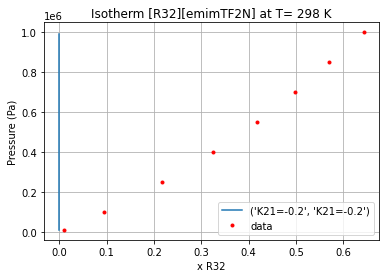

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


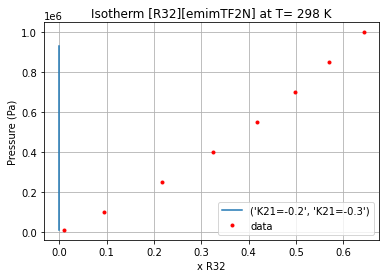

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


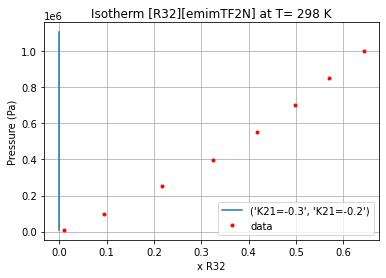

    'pyomo.core.base.param.SimpleParam'>) on block fs with a new Component
    (type=<class 'pyomo.core.base.param.SimpleParam'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.SimpleConstraint'>) on block fs with a new
    Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


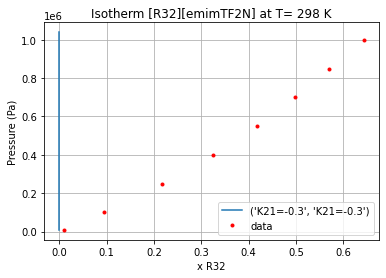

In [7]:
# kappa21= np.array([-0.200,-0.30,-0.40,-0.5])
# kappa12= np.array([-0.056,-0.066,-0.076,-0.086])
kappa21= np.array([-0.200,-0.30])
kappa12= np.array([-0.056,-0.066])
# K21_label = ['K21=-0.2','K21=-0.3','K21=-0.4','K21=-0.5']
# K12_label= ['K12=-0.056', 'K12=-0.066','K12=-0.076','K12=-0.086']
K21_label = ['K21=-0.2','K21=-0.3']
K12_label= ['K12=-0.056', 'K12=-0.066']
# plot_sens_analysis(data_298,kappa21,kappa12, "T=298 K")

# plot function to see if it works - works when i store value, plot, store value 2, plot 2 etc
def plot_sens_analysis(data,kappa21,kappa12,T_label, K21_label, K12_label):
    x1= np.array([[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]])
    P1= np.array([[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]])
    for i in range(len(kappa21)):
        for j in range(len(kappa12)):
            # store data
            x1[i,:],P1[i,:]= calc_outlet_xP(data, kappa21[i],kappa12[j])
            # plot data
            plt.plot(x1[i,:],P1[i,:],label= (K21_label[i],K21_label[j]))
             
                
                
                
                
                
                
                
                
                
                
                
            plt.plot(data["x_R32"],data["pressure"],"r.",label="data")  
            plt.title('Isotherm [R32][emimTF2N] at '+ T_label)
            plt.ylabel('Pressure (Pa)')
            plt.xlabel('x R32')
            plt.grid(True)
            plt.legend()
            plt.show()
plot_sens_analysis(data_298,kappa21,kappa12,"T= 298 K", K21_label, K12_label)        


In [18]:
import numpy as np
x1 = [[1,2,3],[4,5,6]]
print(x1)
np.append(x1, [[45],[90]],axis = 1)




[[1, 2, 3], [4, 5, 6]]


array([[ 1,  2,  3, 45],
       [ 4,  5,  6, 90]])